In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
class VAE():
    def __init__(self, input_dim, hidden_dims, latent_dim, kld_weight=1.0, sess=None):
        #self 54 [20,20] 2 kld_weight=10
        self.input_dim = input_dim
        self.hidden_encoder_dim = hidden_dims[0] #20
        self.hidden_decoder_dim = hidden_dims[1] #20
        self.latent_dim = latent_dim #2→μ,Σ
        self.kld_weight = kld_weight
        
        self.construct_graph()
        
        if sess!=None:
            self.sess = sess
        else:
            self.sess = tf.Session()
            self.sess.run(tf.global_variables_initializer())

    def weight_variable(self, shape):
        initial = tf.truncated_normal(shape, stddev=0.001)
        return tf.Variable(initial)

    def bias_variable(self, shape):
        initial = tf.constant(0., shape=shape)
        return tf.Variable(initial)

    def construct_graph(self):
        # データ用placeholder
        self.x = tf.placeholder(tf.float32, shape=[None, self.input_dim])
       
        # 事前分布のパラメータ
        self.mu_prior = tf.placeholder( tf.float32, shape=[None, self.latent_dim]) #average
        self.logvar_prior = tf.placeholder( tf.float32, shape=[None, self.latent_dim]) #variance

        # 入力→隠れ層 
        W_encoder_input_hidden = self.weight_variable([self.input_dim,self.hidden_encoder_dim]) #54×20のガウス分布
        b_encoder_input_hidden = self.bias_variable([self.hidden_encoder_dim]) #20の0

        # 隠れ層の出力値
        hidden_encoder = tf.nn.relu(tf.matmul(self.x, W_encoder_input_hidden) + b_encoder_input_hidden) #行列の掛け算のちバイアスのちrelu

        # 隠れ層→潜在変数の平均と分散
        W_encoder_hidden_mu = self.weight_variable([self.hidden_encoder_dim,self.latent_dim]) #20*2のガウス分布
        b_encoder_hidden_mu = self.bias_variable([self.latent_dim]) #2の0
        
        W_encoder_hidden_logvar = self.weight_variable([self.hidden_encoder_dim,self.latent_dim]) #20*2 gaussian
        b_encoder_hidden_logvar = self.bias_variable([self.latent_dim]) #2 no 0

        # 平均と分散
        mu_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_mu) + b_encoder_hidden_mu #隠れ層の出力に重みかけてバイアス加算
        logvar_encoder = tf.matmul(hidden_encoder, W_encoder_hidden_logvar) + b_encoder_hidden_logvar #隠れ層の出力に重みかけてバイアス加算

        # 潜在変数のサンプリング
        epsilon = tf.random_normal(tf.shape(logvar_encoder), name='epsilon')
        std_encoder = tf.exp(0.5 * logvar_encoder)
        self.z = mu_encoder + tf.multiply(std_encoder, epsilon)

        # 潜在変数→隠れ層
        W_decoder_z_hidden = self.weight_variable([self.latent_dim, self.hidden_decoder_dim])
        b_decoder_z_hidden = self.bias_variable([self.hidden_decoder_dim])

        # 隠れ層の値
        hidden_decoder = tf.nn.relu(tf.matmul(self.z, W_decoder_z_hidden) + b_decoder_z_hidden)

        # 隠れ層→出力層
        W_decoder_hidden_reconstruction = self.weight_variable([self.hidden_decoder_dim, self.input_dim])
        b_decoder_hidden_reconstruction = self.bias_variable([self.input_dim])

        # 出力値
        self.x_hat = tf.matmul(hidden_decoder, W_decoder_hidden_reconstruction) + b_decoder_hidden_reconstruction
        
        # 目的関数（KL距離とMSE）
        #KLD = -0.5 * tf.reduce_sum(1 + logvar_encoder - tf.pow(mu_encoder, 2) - tf.exp(logvar_encoder), reduction_indices=1)
        KLD = -0.5 * tf.reduce_sum(1 + self.logvar_prior + logvar_encoder - (tf.pow(mu_encoder-self.mu_prior, 2) + tf.exp(logvar_encoder))/tf.exp(self.logvar_prior), reduction_indices=1)
        
        #BCE = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=x_hat, labels=x), reduction_indices=1)
        MSE = tf.reduce_sum( tf.squared_difference(self.x_hat, self.x), reduction_indices=1)

        #loss = tf.reduce_mean(100*BCE+KLD )
        self.loss = tf.reduce_mean(MSE+KLD*self.kld_weight )
        self.train_step = tf.train.AdamOptimizer(0.01).minimize(self.loss)
        
        # 再構成用のネットワーク(サンプリングをしない)
        self.z_reconst = mu_encoder
        hidden_decoder = tf.nn.relu(tf.matmul(self.z_reconst, W_decoder_z_hidden) + b_decoder_z_hidden)
        self.x_reconst = tf.matmul(hidden_decoder, W_decoder_hidden_reconstruction) + b_decoder_hidden_reconstruction

        
    def train(self, x_data, n_steps, mu_prior, logvar_prior):
        self.losses = []
            
        feed_dict = {self.x: x_data, self.logvar_prior: logvar_prior, self.mu_prior: mu_prior}
        for step in range(1, n_steps):
            _, cur_loss, self.z_, self.x_ = self.sess.run([self.train_step, self.loss, self.z, self.x_hat], feed_dict=feed_dict)
            self.losses.append(cur_loss)

            if step % 100 == 0:
                print("%03d - %lf" % (step, cur_loss))
                    

        z, x = self.sess.run( [self.z_reconst, self.x_reconst], feed_dict=feed_dict )

        # plot        
        plt.title("latent variables")
        plt.plot( z[:,0], z[:,1], "-o" )

        plt.figure()
        plt.title("recostructed input")
        t = range(len(self.x_))
        for d in range(self.input_dim):
            plt.plot( t, x[:,d] )

        plt.figure()
        plt.title("loss")
        plt.plot( range(len(self.losses)), self.losses )
        plt.show()

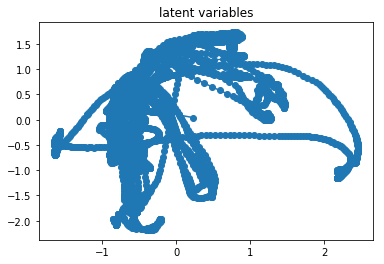

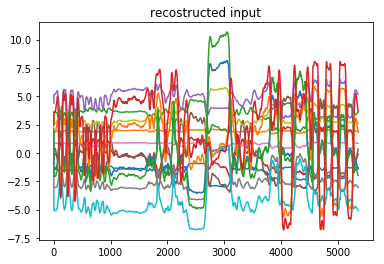

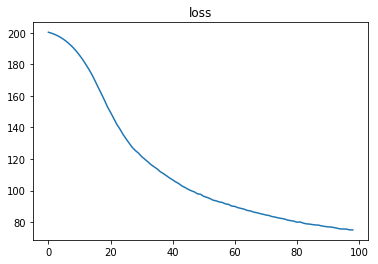

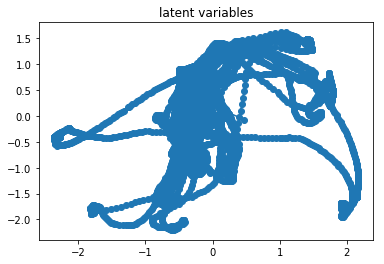

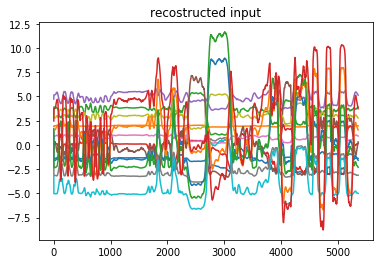

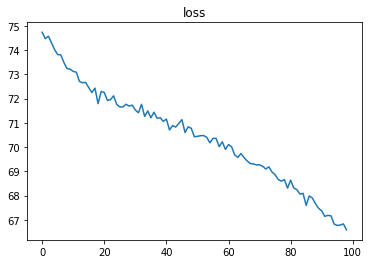

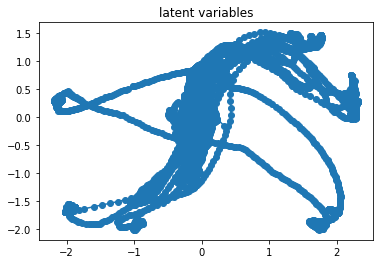

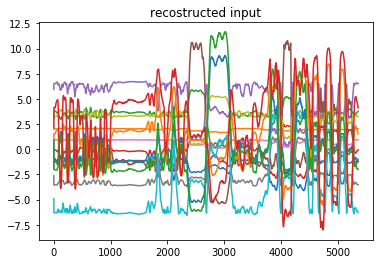

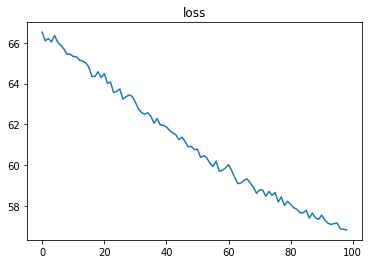

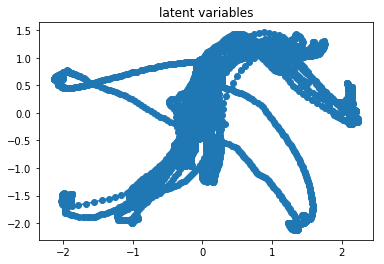

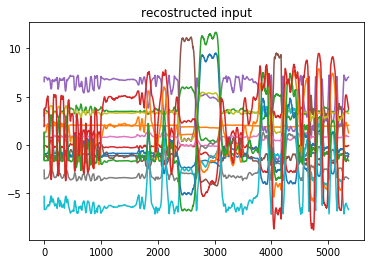

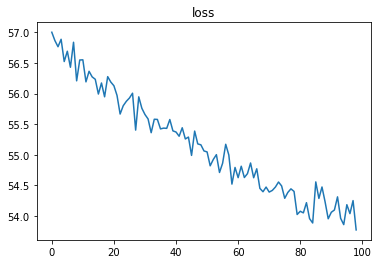

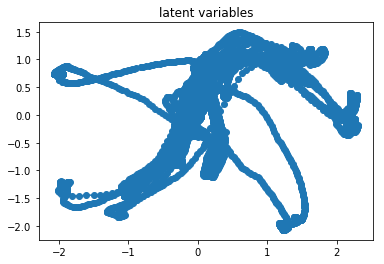

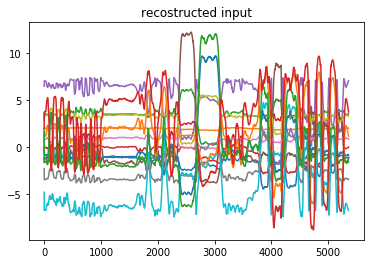

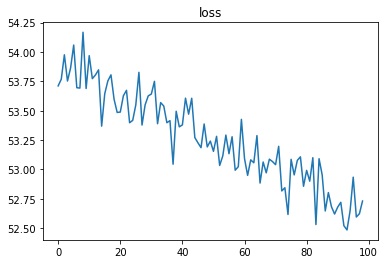

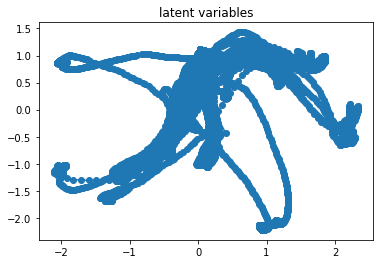

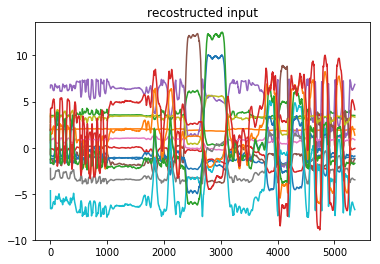

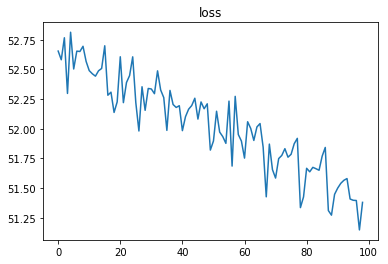

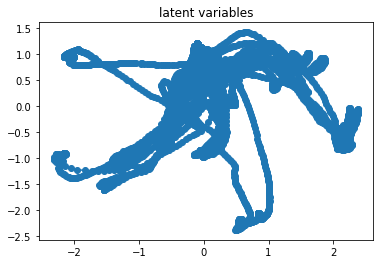

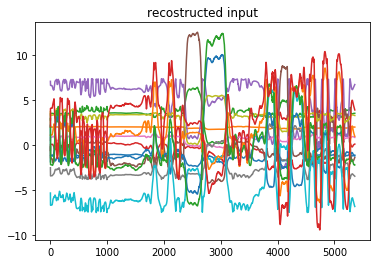

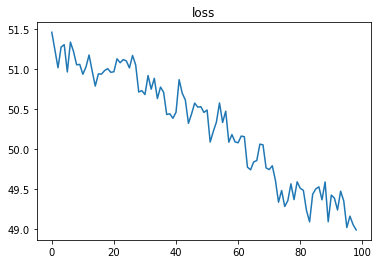

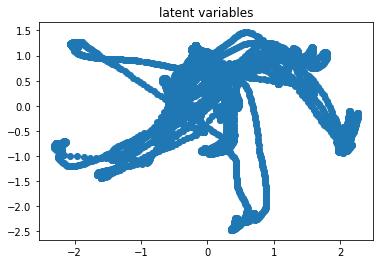

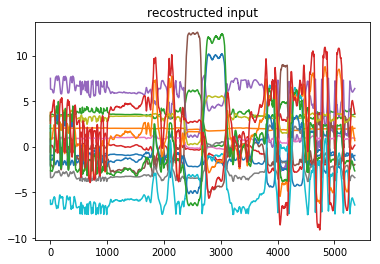

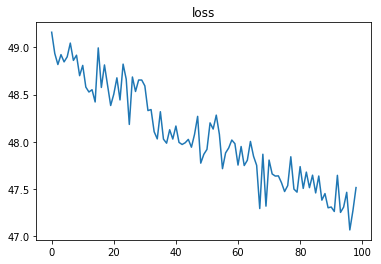

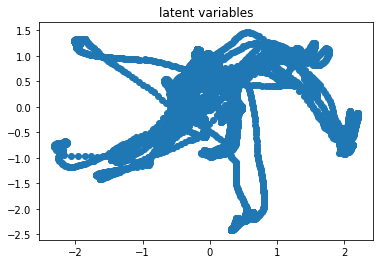

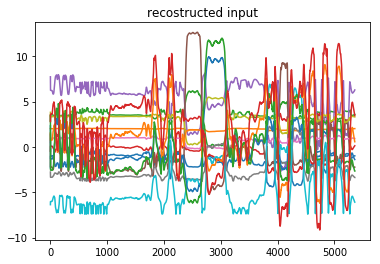

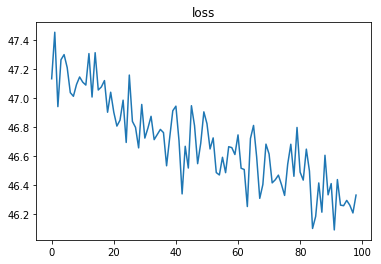

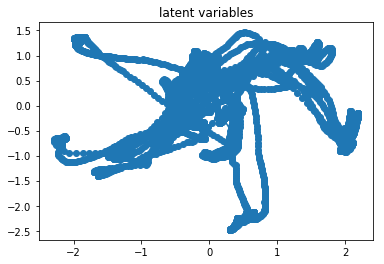

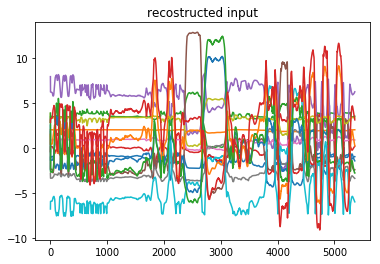

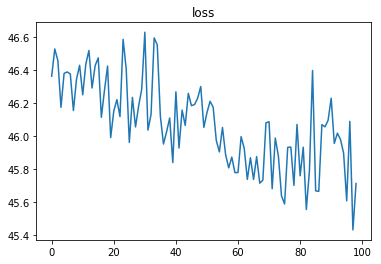

In [5]:
x_data = np.loadtxt( "000.txt" )
N = len(x_data)

with tf.Session() as sess :
    vae = VAE(len(x_data[0]), [20,20], 2, kld_weight=10, sess=sess)
    sess.run(tf.global_variables_initializer())

    mu_prior = np.zeros( (N,2)  )
    logvar_prior = np.zeros( (N,2) )
    for it in range(10):
        # VAE学習
        vae.train( x_data, 100, mu_prior, logvar_prior )